## Семинар 6

## Логистическая регрессия и SVM

#### План:
1. Логистическая регрессия
2. SVM.
3. Ирисы Фишера. Свойства логистической регрессии и SVM
4. Логистическая регрессия и SVM на менее приятных данных.
5. ROC-кривая.
6. Бонус: вывод логистической регрессии через правдоподобие
---

### Логистическая регрессия

Напомним, что мы по-прежнему решаем задачу бинарной классификации, в которой целевая переменная $y$ принимает два значения: -1 и 1. На прошлом семинаре мы обсудили, что эту задачу можно решить при помощи линейного классификатора

$$
f(x_i, w) = \mathrm{sign}\left(\langle x_i, w \rangle\right).
$$

Функция потерь для такой задачи – это сумма индикаторов того, что предсказание сделано неверно:

$$Q(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}[y_i \ne \mathrm{sign}\left(\langle x_i, w \rangle\right)].$$

На лекциях мы обсуждали, что эту идею можно удобно записать через функцию отступа:

$$
Q(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}[y_i \langle x_i, w \rangle < 0].
$$

Такую функцию проблематично дифференцировать по $w$, потому что даже в местах, где градиент существует, он равен нулю. Вместо этого будем минимизировать некоторую функцию $\tilde{Q}(X, w)$, являющуюся верхней оценкой для $Q(X, w)$, и надеяться, что минимизация $\tilde{Q}(X, w)$ позволит достаточно хорошо минимизировать и $Q(X, w)$.

Логистическая регрессия предлагает использовать логистическую функцию потерь:

$$
\tilde{Q}(X, w) = \frac{1}{\ell}\sum_{i = 1}^{\ell}\log(1 + e^{-y_i \langle x_i, w \rangle}) \rightarrow \min_w.
$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

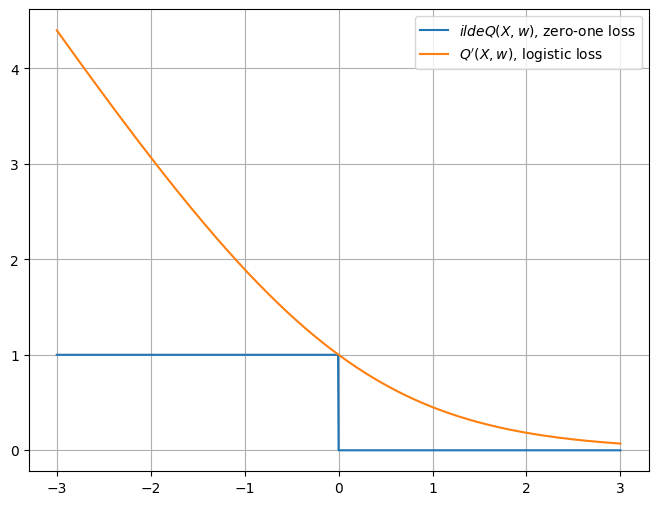

In [2]:
x = np.concatenate((np.linspace(-3, 0, 500), np.linspace(0, 3, 500)))
np.random.seed(123)
y = np.ones(1000)
w = np.ones(1000)
M = y * x * w

plt.figure(figsize = (8, 6))
plt.plot(x * w, x < 0, label = "$\tilde{Q}(X, w)$, zero-one loss")
plt.plot(M, np.log2(1 + np.exp(-M)), label = "$Q'(X, w)$, logistic loss")
plt.grid()
plt.legend();

Для получения классической задачи логистической регрессии остаётся сделать один шаг и немного изменить постановку задачи. Предположим, что мы хотим решать задачу **мягкой** классификации, то есть предсказывать не метку класса, а вероятность того, что наблюдение принадлежит к классу. Понятно, что мы всегда можем перейти от мягкой классификации к жёсткой, выбрав порог принадлежности к положительному классу.

**Задание 1.** Поясните, почему для решения задачи мягкой классификации классификатор $f(x_i, w) = \left(\langle x_i, w \rangle\right)$ – не лучший выбор.

**Ответ:**

Полученное скалярное произведение необязательно будет лежать в отрезке $[0, 1]$.

Мы можем решить названную проблему, подставив $\left(\langle x_i, w \rangle\right)$ в некоторую функцию, областью значений которой является промежуток от 0 до 1. В логистической регрессии такой функцией выступает **сигмоида**:

$$
\sigma(x) = \dfrac{e^x}{1 + e^x} = \dfrac{1}{1 + e^{-x}}.
$$

**Задание 2.** Сигмоида обаладет замечательнеым свойством, которое значительно упрощает вычисление градиентов при градиентном спуске:

$$
\sigma(x)'_x = \sigma(x)(1 - \sigma(x)).
$$

Покажите, что это действительно так.

**Решение:**

$$
\sigma(x)' = \frac{e^x(1 + e^x) - e^{2x}}{(1 + e^x)^2} = \frac{e^x}{1 + e^x}\frac{1}{1 + e^x} = \sigma(x)(1-\sigma(x)).
$$

Путём хитрых математических преобразований можно показать, что при использовании сигмоиды (= при решении задачи мягкой классификации) $\tilde{Q}(X, w)$ можно записать в следующем виде:

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle)
$$

Эта функция называется log-loss или кросс-энтропией между истинной целевой переменной и предсказанными вероятностями.

**А почему? А потому:**

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle) =\\
$$
$$
=-\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\left(\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right) + [y_i = -1](\log\left(1-\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right)) =\\
$$
$$
=-\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\left(\frac{1}{1 + e^{-\langle x_i, w\rangle}}\right) + [y_i = -1](\log\left(\frac{1}{1 + e^{\langle x_i, w\rangle}}\right)) =\\
$$
$$
=\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log(1 + e^{-\langle x_i, w \rangle}) + [y_i = -1]\log(1 + e^{\langle x_i, w \rangle}) =\\
$$
$$
=\frac{1}{\ell} \sum_{i=1}^{\ell}\log(1 + e^{-y_i\langle x_i, w\rangle}) = \tilde{Q}(X, w)
$$

Регуляризация вводится таким же образом, как это было в случае линейной регрессии. Например, функция потерь для $\ell$-$2$ регуляризации выглядит так:

$$
\tilde{Q}_{reg}(X, w) = \tilde{Q}(X, w) + \frac{1}{2}\lambda\|w\|^2_2.
$$

**Саммари по логистической регрессии:**

- Данные: $y_i \in \{-1, 1\}$, $X$

- Предсказания:

    - По умолчанию предсказывает вероятности:
    $$
    \hat{p}_i = \sigma(\langle x_i, w\rangle) = \frac{1}{1 + e^{-\langle x_i, w\rangle}}
    $$
    
    - Если хотим перейти к метке, то сравниваем вероятность с порогом $t$:
    
    $$
    \hat{y}_i = \begin{cases}
    1,&\text{ если } \hat{p}_i > t,\\
    -1,&\text{ иначе.}
    \end{cases}
    $$
    
- Обучение:

$$
\tilde{Q}(X, w) = -\frac{1}{\ell} \sum_{i=1}^{\ell} [y_i = 1]\log\sigma(\langle x_i, w \rangle) + [y_i = -1]\log(1-\sigma(\langle x_i, w \rangle) \to \min_w
$$

### Метод опорных векторов (SVM)

Метод опорных векторов – математически строго обоснованный метод, идея которого состоит в максимизации ширины разделяющей полосы между классами. Так как для подробного вывода SVM требуется уверенное владение методами квадратичной оптимизации, мы разберём только идею и практическую реализацию метода.

Мы по-прежнему решаем задачу бинарной классификации и используем классификатор $f(x_i, w) = \mathrm{sign}(\langle x_i, w\rangle)$. Предположим, что мы работаем с линейно разделимой выборкой. Определим отступ как минимальное расстояние от точек выборки до разделяющей поверхности классификатора:
$$
\rho(x_i, \langle x, w\rangle) =  \min_i\dfrac{|{\langle x_i, w\rangle|}}{\|w\|}
$$

Задача состоит в том, чтобы максимизировать этот отступ:

$$
\rho(x_i, \langle x, w\rangle) =  \min_i\dfrac{|{\langle x_i, w\rangle|}}{\|w\|} \to \max_w.
$$

Воспользуемся картинкой из Википедии, чтобы лучше понять эту идею:

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" alt="drawing" width="400"/>](https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:SVM_margin.png)

Заметим, что при делении весов на положительное число ответы классификатора не меняются (веса просто пропорционально прошкалируются). Поделим все веса на

$$\min_i |\langle x_i, w\rangle| > 0.$$

Тогда будет верно, что $\min_i |\langle x_i, w\rangle| = 1$, а значит отступ можно переписать как

$$
\rho(\langle x_i, w\rangle) = \frac{1}{\|w\|}.
$$

Получаем задачу SVM в линейно-разделимом случае:

$$
\begin{cases}
\|w\|^2 \to \min_{w}, \\
y_i(\langle x_i, w\rangle) \ge 1, \\
\end{cases}
$$

Если выборка не является линейно-разделимой, то нам придётся позволить линейному классификатору допускать ошибки на некоторых наблюдениях. Тогда задача превращается в поиск оптимального выбора между максимизацией ширины разделяющей полосы и ошибок классификации:

$$
\begin{cases}
\|w\|^2 + C \sum_{i = 1}^{\ell} \xi_i \to \min_{w, \xi_i}, \\
y_i(\langle x_i, w\rangle) \ge 1 - \xi_i, \\
\xi_i \ge 0
\end{cases}
$$

$C$ – параметр, который позволяет регулировать пропорции этого выбора. Чем больше $C$, тем больше штраф за неверную классификацию.

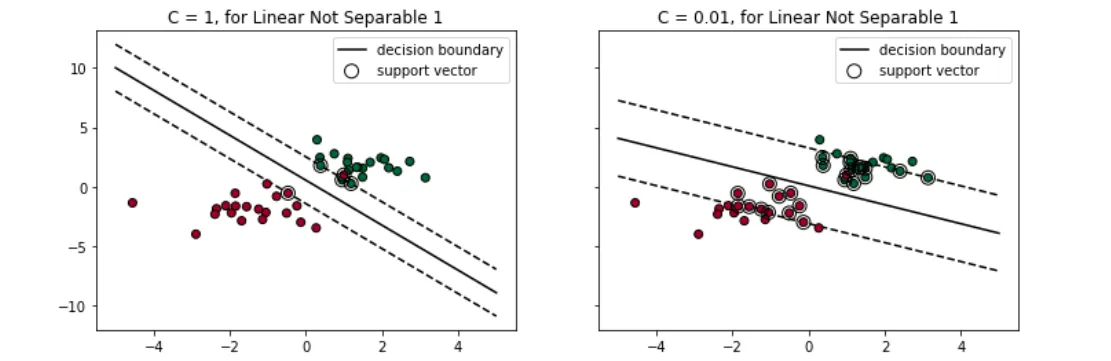

Путём хитрых математических преобразований (объединив ограничения) можно показать, что итоговая функция потерь SVM выглядит следующим образом:

$$
Q(X, w) = C\sum_{i=1}^{l} \max\{0, 1 - y_i(\langle x_i, w\rangle)\} + \|w\|^2 \to \min_w
$$

### Ирисы Фишера. Свойства логистической регрессии и SVM

Рассмотрим свойства логистической регрессии и метода опорных векторов на примере классического набора данных ["Ирисы Фишера"](https://ru.wikipedia.org/wiki/Ирисы_Фишера). Этот набор состоит из 150 наблюдений, каждое из которых представляет собой четыре измерения: длина наружной доли околоцветника (`sepal length`), ширина наружной доли околоцветника (`sepal width`), длина внутренней доли околоцветника (`petal length`), ширина внутренней доли околоцветника (`petal width`). Каждое наблюдение относится к одному из трёх классов ириса: `setosa`, `versicolor` или `virginica`. Задача состоит в том, чтобы по измерениям предсказать класс цветка.

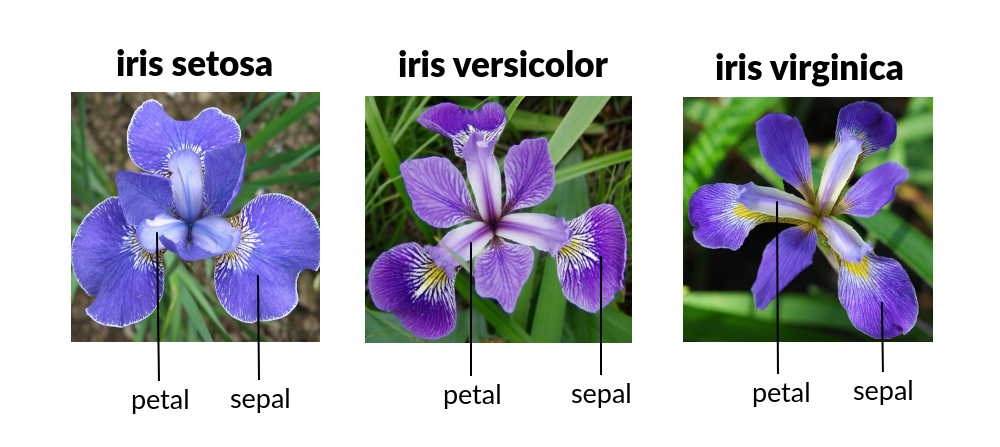

In [3]:
from sklearn.datasets import load_iris
data = load_iris()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [5]:
print(data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

**Задание 1.** Перейдём к задаче бинарной классификации: будем предсказывать принадлежность цветка к виду `versicolor` против принадлежности ко всем прочим видам. Перекодируйте зависимую переменную так, чтобы цветки вида `versicolor` имели метку 1, а прочих видов – метку -1.

In [6]:
# Перекодировка
y[y != 1] = -1

**Задание 2**. Будем работать с двумя признаками: `sepal length (cm)` и `sepal width (cm)`. Отделите их в отдельную матрицу. Разделите выборку на обучающую и тестовую, долю тестовой выборки укажите равной 0.3. Отмасштабируйте выборки при помощи StandardScaler. Постройте диаграмму рассеяния по тренировочной выборке и убедитесь, что данные линейно не разделимы.

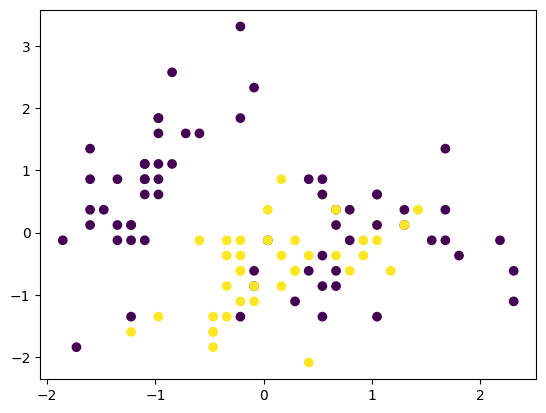

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
np.random.seed(123)

X = X[['sepal length (cm)', 'sepal width (cm)']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Отмасштабируйте признаки
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train)

**Задание 3.** Обучите логистическую регрессию и **SVM с линейным ядром** на тренировочной выборке и убедитесь, что полученные оценки весов действительно различаются. Убедитесь, что `accuracy`, возможно, не подходит в качестве метрики для данной задачи и рассчитайте `f1-меру` на тестовой выборке. Какой алгорим показал более высокое качество?

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [9]:
lr = LogisticRegression()
svm = SVC(kernel = 'linear')

# Обучите логистическую регрессию и SVM
lr.fit(X_train, y_train)
svm.fit(X_train, y_train)

pred_lr = lr.predict(X_test)
pred_svm = svm.predict(X_test)

In [10]:
probs_lr = lr.predict_proba(X_test) # честные вероятности

probs_lr[:,1]

array([0.70582039, 0.42794507, 0.53247213, 0.36230936, 0.09432892,
       0.38375271, 0.80014277, 0.20546421, 0.35790671, 0.6072464 ,
       0.37207571, 0.02507765, 0.52771287, 0.4111971 , 0.47903627,
       0.4111971 , 0.13373592, 0.29663036, 0.45147437, 0.32109053,
       0.15695079, 0.52676074, 0.14519472, 0.38918871, 0.06133819,
       0.16311372, 0.16311372, 0.4866686 , 0.10602806, 0.09630583,
       0.58887916, 0.82841232, 0.21691978, 0.12346406, 0.82841232,
       0.74822088, 0.1104534 , 0.05140326, 0.05140326, 0.56181281,
       0.86496686, 0.22883011, 0.30954298, 0.42234205, 0.56181281])

In [11]:
pred_lr

array([ 1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,
        1,  1, -1, -1, -1,  1,  1, -1, -1, -1,  1])

In [12]:
from sklearn.metrics import accuracy_score, f1_score

f1_score(y_test, pred_lr)

0.6956521739130435

In [13]:
f1_score(y_test, pred_svm)

0.8

In [14]:
lr.coef_, lr.intercept_

(array([[ 0.1816305 , -1.04223331]]), array([-0.63278647]))

In [15]:
svm.coef_ #w, svm.intercept_ #w_0

array([[-3.78448050e-05, -1.01771688e+00]])

Теперь посмотрим, как различаются решающие поверхности алгоритмов.

Код ниже построит решающие поверхности для классификаторов. Чтобы он заработал, нужно обязательно сделать `fit` для `lr` и `svm` выше.

In [16]:
# !pip install mlxtend

# В Колабе, возможно
!pip install mlxtend --upgrade

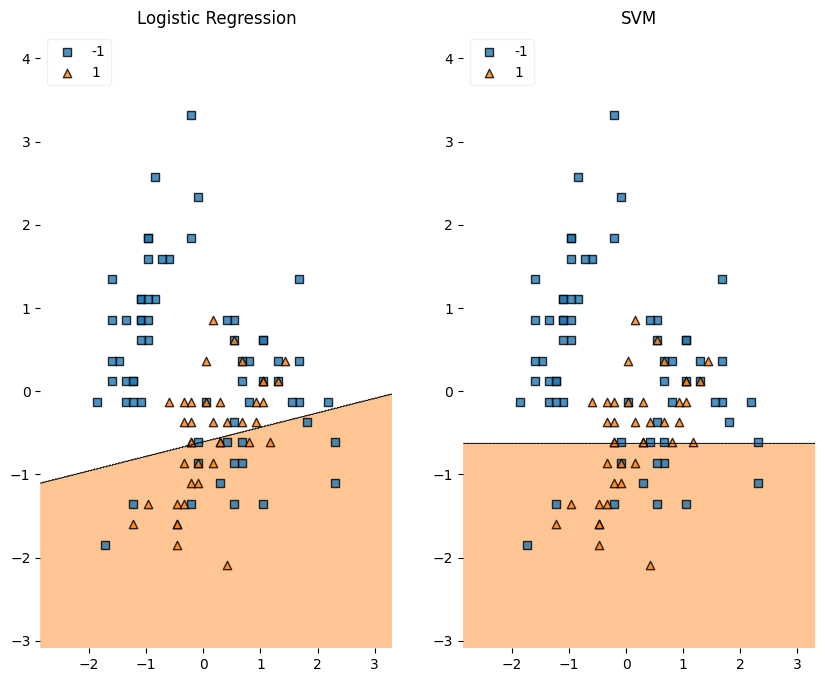

In [17]:
import itertools

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from mlxtend.plotting import plot_decision_regions

gs = gridspec.GridSpec(1, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'SVM']
for clf, lab, grd in zip([lr, svm],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = np.array(X_train), y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

Теперь изучим свойства каждого классификатора по-отдельности. Начнём с логистической регрессии.

**Задание 3.** Обучите три различные логистические регрессии с разным параметром регуляризации $\alpha$ (обратите внимание, что в реализации `sklearn` $C = 1/\alpha$). Как изменяется разделяющая поверхность в зависимости от $\alpha$?

In [18]:
lr1 = LogisticRegression(C = 0.01)
lr2 = LogisticRegression(C = 0.05)
lr3 = LogisticRegression(C = 10)

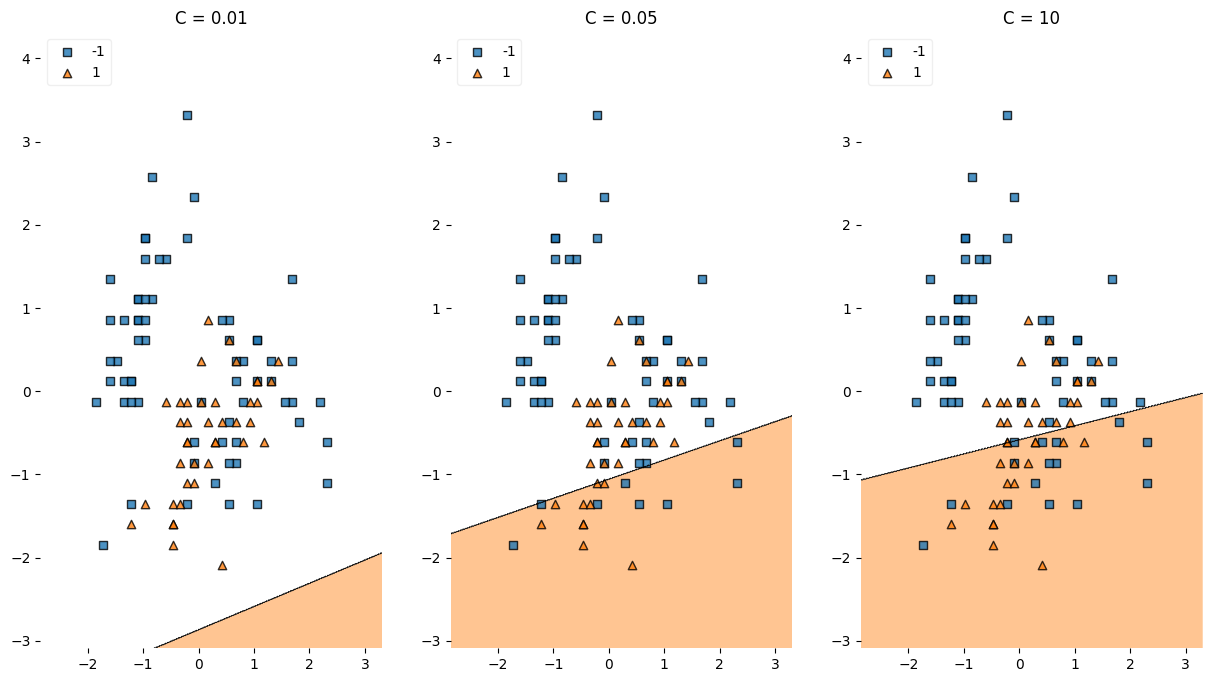

In [19]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15,8))

labels = ['C = 0.01', 'C = 0.05', 'C = 10']
for clf, lab, grd in zip([lr1, lr2, lr3],
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X_train, y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задание 4.** Теперь посмотрим на решение задачи мягкой классификации. При помощи метода `predict_proba()` любой из обученных логистических регрессий сделайте предсказание вероятностей положительного класса.

In [20]:
ans = pd.DataFrame(clf.predict_proba(X_train)[:,1], columns = ['preds'])
ans['fact'] = y_train
ans.sort_values(by = 'preds', ascending = False, inplace = True)
ans

,preds,fact
85,0.853384,1
2,0.789157,1
15,0.746725,-1
47,0.742156,-1
26,0.739881,1
...,...,...
24,0.052495,-1
3,0.052495,-1
40,0.036436,-1
90,0.024298,-1


Перейдём к SVM.

**Задание 4.** Обучите три SVM с линейным ядром с разным параметром регуляризации $C$. Как изменяется разделяющая поверхность в зависимости от $C$?

In [21]:
svc1 = SVC(C = 0.04, kernel = 'linear')
svc2 = SVC(C = 1, kernel = 'linear')
svc3 = SVC(C = 10, kernel = 'linear')

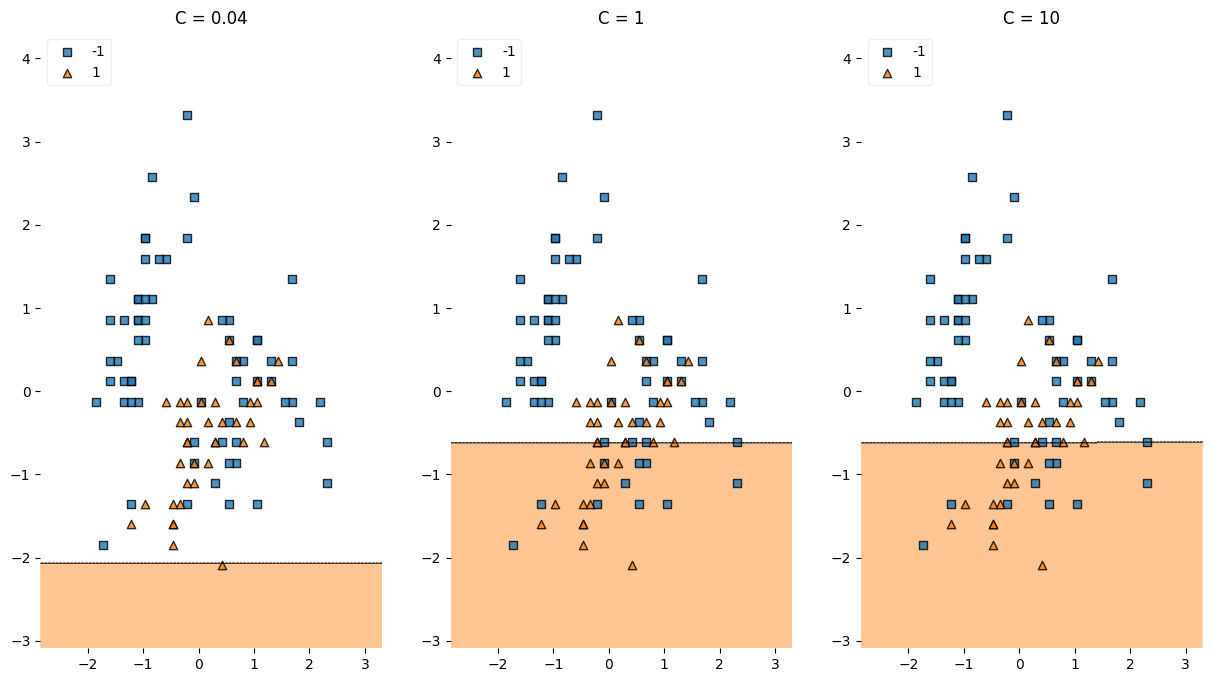

In [22]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(1, 3)

fig = plt.figure(figsize=(15,8))

labels = ['C = 0.04', 'C = 1', 'C = 10']
for clf, lab, grd in zip([svc1, svc2, svc3],
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X = X_train, y = np.array(y_train), clf=clf, legend=2)
    plt.title(lab)

plt.show()

### Логистическая регрессия и SVM на менее приятных данных (если есть время)

Мы будем работать с [набором данных](https://www.kaggle.com/piyushgoyal443/red-wine-dataset?select=wineQualityReds.csv), содержащим информацию о характеристиках вина. Каждое наблюдение принадлежит к одному из 10 категорий качества вина, и наша задача заключается в том, что предсказать эту категорию.

In [24]:
data = pd.read_csv('https://raw.githubusercontent.com/KSTSV/DA_9_machine_learning/refs/heads/main/lec_sem_5/wineQualityReds.csv', index_col = 0)
data.head()

,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,,,,,,,,,,,
7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Как указано в описании набора, в нём нет пропущенных значений, и все переменные являются непрерывными. Целевая переменная – `quality`.

**Задание 1.** Перейдём к задаче бинарной классификации и будем предсказывать только наиболее популярную категорию качества. Закодируйте столбец `quality` так, чтобы наиболее частая категория (это категория 5) получила метку 1, а все прочие категории – метку -1.

In [25]:
data.quality[data.quality == 5] = 1
data.quality[data.quality != 1] = -1

<ipython-input-25-9e124cc4a655>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.quality[data.quality == 5] = 1
<ipython-input-25-9e124cc4a655>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.quality[data.quality != 1] = -1


In [26]:
data.quality.value_counts()

,count
quality,
-1,918
1,681


**Задание 2.** Разделите признаки и целевую переменную. Разделите выборку на тренировочную и тестовую, долю тестовой выборки укажите равной 0.3. При помощи `StandardScaler` отмасштабируйте тренировочную и тестовую выборки.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [28]:
X = data.iloc[:, :-1]
y = data.quality

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Отмасштабируйте признаки
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

**Задание 3.** При помощи кросс-валидации (параметры выберите сами) подберите оптимальные значения коэффициентов регуляризации для логистической регрессии и SVM с линейным ядром. Обучите модели с этими параметрами. Убедитесь, что доля правильных ответов – не лучший вариант для нашей задачи и рассчитайте F-меру на тестовой выборке. Какой алгоритм показал себя лучше?

 **Бонус для самых отважных:** качество работы SVM можно улучшить за счёт применения ядер, после чего разделяющая поверхность становится нелинейной. Если вам интересно, попросите семинариста рассказать об этом подробнее.  

In [30]:
from sklearn.model_selection import cross_validate

scores_svm = []

for c in np.arange(0.1, 20, 0.5):
    svm = SVC(C = c)
    svm.fit(X_train, y_train)

    pred_svm = svm.predict(X_test)

    print(f1_score(y_test, pred_svm), f'C={c}')
    pass

0.6531645569620254 C=0.1
0.6585365853658537 C=0.6
0.681265206812652 C=1.1
0.6780487804878049 C=1.6
0.6796116504854369 C=2.1
0.681265206812652 C=2.6
0.6876513317191283 C=3.1
0.6889952153110048 C=3.6
0.684085510688836 C=4.1
0.6872037914691943 C=4.6
0.6842105263157895 C=5.1
0.6842105263157895 C=5.6
0.6826923076923077 C=6.1
0.6810551558752997 C=6.6
0.6810551558752997 C=7.1
0.6810551558752997 C=7.6
0.6842105263157895 C=8.1
0.6826923076923077 C=8.6
0.6843373493975904 C=9.1
0.6859903381642513 C=9.6
0.6876513317191283 C=10.1
0.6876513317191283 C=10.6
0.6941747572815534 C=11.1
0.6941747572815534 C=11.6
0.6941747572815534 C=12.1
0.6941747572815534 C=12.6
0.6941747572815534 C=13.1
0.6941747572815534 C=13.6
0.6941747572815534 C=14.1
0.6958637469586375 C=14.6
0.6894865525672371 C=15.1
0.6878048780487804 C=15.6
0.6894865525672371 C=16.1
0.6861313868613139 C=16.6
0.6861313868613139 C=17.1
0.6861313868613139 C=17.6
0.6844660194174758 C=18.1
0.6844660194174758 C=18.6
0.6844660194174758 C=19.1
0.6859903

In [31]:
svm

SVC(C=19.6)

### ROC-кривая

Ранее мы узнали, что помимо accuracy в задачах классификации так же используются precision, recall и f-мера. Теперь пришло время познакомиться с ещё одной метрикой – ROC AUC.

Для начала вспомним, что мы работаем с матрицей ошибок:

|       | alg = 1          | alg = -1    |
|-------| -----------------|-------------|
|y = 1  |TP                |FN           |
|y = -1 |FP                | TN          |

Определим следующие величины:

$$
TPR \text{ (true positive rate, recall, sensitivity)} = \dfrac{TP}{TP + FN}
$$
– доля правильно предсказанных объектов положительного класса.

$$
FPR \text{ (false positive rate, 1 - specificity)} = \dfrac{FP}{FP + TN}
$$
– доля неправильно предсказанных объектов отрицательного класса.

Рассмотрим задачу мягкой классификации: мы предказываем вероятности принадлежности наблюдения к положительному и отрицательному классам. Тогда TPR и FPR будут зависеть от порога для вероятности, выше которого наблюдение будет отнесено к положительному классу. ROC-кривая строится в координатах $(FPR, TPR)$ и показывает комбинации TPR и FPR при всевозможных значениях порога.

Для хорошего классификатора эта кривая является вогнутой, а для идеального классификатора она будет проходить через точку $(0, 1)$ (почему?).

[<img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Roccurves.png" alt="drawing" width="350"/>](https://ru.wikipedia.org/wiki/ROC-кривая)



**Задание 1.** Постройте ROC-кривую для следующей выборки.

In [32]:
# True labels
y = [-1, 1, 1, -1, 1, 1]
# Predicted labels
p = [0.5, 0.1, 0.2, 0.9, 0.7, 0.1]

**Решение:**
1. Упорядочим наблюдения по **убыванию** ответов алгоритма.

In [33]:
y = [-1, 1, -1, 1, 1, 1]
p = [0.9, 0.7, 0.5, 0.2, 0.1, 0.1]

2. Разобьём единичный квадрат на $(m, n)$ частей, где $m$ – число 1 в $y$, $n$ – число нулей. Стартуем из точки $(0, 0)$. Если значение $y$ равно 1, делаем шаг вверх, а если -1 – вправо. Понятно, что конечная точка нашего маршрута – точка $(1, 1)$.

**Важный момент:** если у нескольких объектов значения предсказаний равны, а $y$ – различны, то мы должны сделать ход "по диагонали".

Если построить кривую по этому алгоритму, то получим:

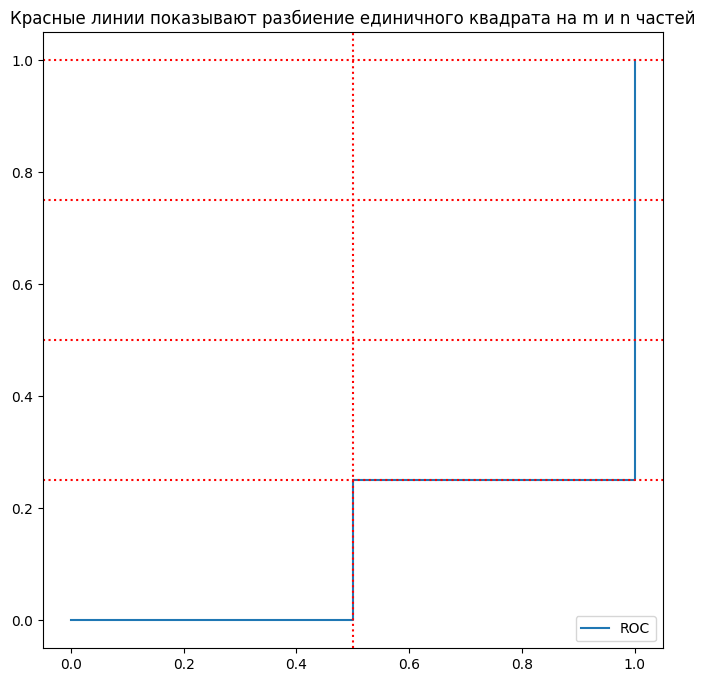

In [34]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y, p)

plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC')
plt.axvline(0.5, linestyle = 'dotted', c = 'red')
plt.axhline(0.25, linestyle = 'dotted', c = 'red')
plt.axhline(0.5, linestyle = 'dotted', c = 'red')
plt.axhline(0.75, linestyle = 'dotted', c = 'red')
plt.axhline(1.0, linestyle = 'dotted', c = 'red')
plt.title('Красные линии показывают разбиение единичного квадрата на m и n частей')
plt.legend()

3. Полученная кривая и является ROC-кривой.

**(Почему этот алгоритм имеет смысл?)**

**Пример с диагональным шагом.**

In [35]:
p = [0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0]
y = [-1,  -1,   -1, 1,    1,   1,   -1]

In [36]:
fpr, tpr, _ = roc_curve(y, p)

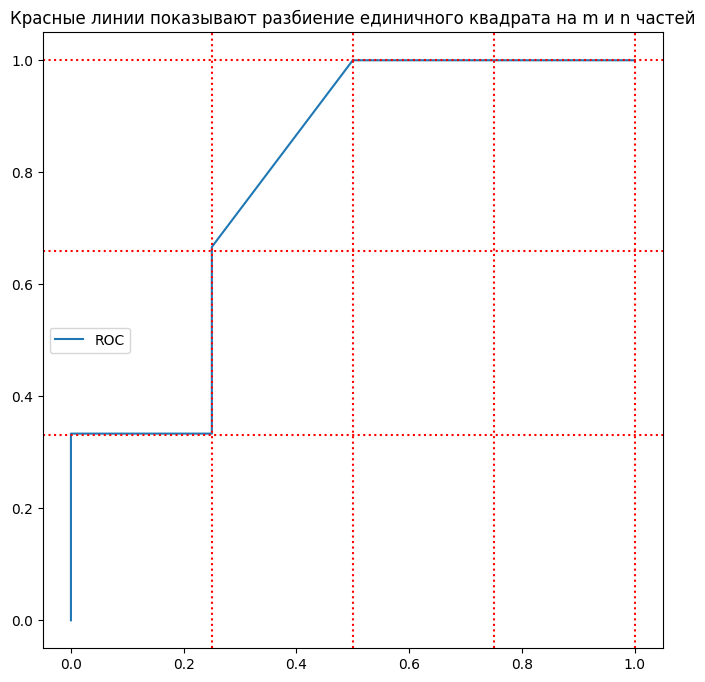

In [37]:
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, label = 'ROC')
plt.axvline(0.25, linestyle = 'dotted', c = 'red')
plt.axvline(0.5, linestyle = 'dotted', c = 'red')
plt.axvline(0.75, linestyle = 'dotted', c = 'red')
plt.axvline(1.0, linestyle = 'dotted', c = 'red')
plt.axhline(0.33, linestyle = 'dotted', c = 'red')
plt.axhline(0.66, linestyle = 'dotted', c = 'red')
plt.axhline(1.0, linestyle = 'dotted', c = 'red')
plt.title('Красные линии показывают разбиение единичного квадрата на m и n частей')
plt.legend()

**Задание 2.** ROC AUC – площадь под ROC-кривой – равна доле пар наблюдений $(y = 1, y = -1)$, которые алгоритм верно упорядочил. Таким образом, чем больше ROC AUC, тем качественнее отработал классификатор. Вычислите ROC AUC для построенной ROC-кривой из первого примера.

**Решение:**

In [38]:
0.25 * 0.5

0.125

**Задание 3.** Как выглядит ROC-кривая для случайного классификатора?


**Задание 4.** Как по ROC-кривой выбрать порог для бинаризации?

В `sklearn` реализовано вычисление значений ROC-кривой и площади под ней.

In [39]:
from sklearn.metrics import roc_curve, auc

**Важно:** в `roc_curve` передаются предсказанные вероятности!

**Задание 5.** Постройте ROC-кривую и рассчитайте площадь под ней для логистической регрессии на данных о вине. О чём говорит такая форма кривой?

In [40]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

# ...

LogisticRegression()

### Бонус для самых смелых: вывод логистической регрессии через правдоподобие

Перекодируем $y$ так, что её возможные значения – это 0 и 1. Теперь $y$ является случайной величиной из распределения Бернулли. Тогда сигмоида задаёт условную вероятность принадлежности $y$ к положительному классу:

$$
P(y_i = 1 | x_i, w) = \sigma(x_i, w).
$$

Будем искать оценку коэффициентов $w$ при помощи метода максимального правдоподобия.

$$
\mathcal{L} = \sigma(x_i, w)^{\sum_i y_i}(1 - \sigma(x_i, w))^{\sum_i 1 - y_i}
$$

Логарифмируем:

$$
\mathcal{l} = \sum_i y_i \log\sigma(x_i, w) + (1 - y_i)(1 - \log\sigma(x_i, w))
$$

Если теперь взять среднее, то мы получим log-loss, взятый со знаком минус. Таким образом, минимизация функции потерь в логистической регрессии эквивалентна  максимизации правдоподобия в задаче нахождения оценок $w$!